In [18]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [19]:
pd.read_csv('sensor9y.csv').head()

,sensor,9y
0,0.039216,235.392
1,0.039216,236.682
2,0.039216,238.002
3,0.039216,237.996
4,0.039216,237.974


In [20]:
train_x = []

# Store csv file in a Pandas DataFrame
df = pd.read_csv('sensor9y.csv')

# Scaling the input data
sc = MinMaxScaler()
label_sc = MinMaxScaler()
data = sc.fit_transform(df.values)
# Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
label_sc.fit(df.iloc[:,1].values.reshape(-1,1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [21]:
# Define lookback period and split inputs/labels
lookback = 10
inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
labels = np.zeros(len(data)-lookback)

for i in range(lookback, len(data)):
    inputs[i-lookback] = data[i-lookback:i]
    labels[i-lookback] = data[i,1]
inputs = inputs.reshape(-1,lookback,df.shape[1])
labels = labels.reshape(-1,1)

In [22]:
# Split data into train/test portions and combining all data from different files into a single array
test_portion = int(0.1*len(inputs))
train_x = inputs[:-test_portion]
train_y = labels[:-test_portion]
test_x = inputs[-test_portion:]
test_y = labels[-test_portion:]

In [23]:
batch_size = 10

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [24]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [25]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [26]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2
    # Instantiating the model
    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            h = h.data
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            #if counter%20 == 0:
            print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model


In [27]:
def evaluate(model, test_x, test_y, label_sc):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    
    inp = torch.from_numpy(np.array(test_x))
    labs = torch.from_numpy(np.array(test_y))
    h = model.init_hidden(inp.shape[0])
    out, h = model(inp.to(device).float(), h)
    outputs.append(label_sc.inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    targets.append(label_sc.inverse_transform(labs.numpy()).reshape(-1))
    
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

In [28]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")

Starting Training of GRU model
Epoch 1......Step: 1/71....... Average Loss for Epoch: 0.16189879179000854
Epoch 1......Step: 2/71....... Average Loss for Epoch: 0.16048164665699005
Epoch 1......Step: 3/71....... Average Loss for Epoch: 0.15511860450108847
Epoch 1......Step: 4/71....... Average Loss for Epoch: 0.13762444630265236
Epoch 1......Step: 5/71....... Average Loss for Epoch: 0.12868608087301253
Epoch 1......Step: 6/71....... Average Loss for Epoch: 0.126322653144598
Epoch 1......Step: 7/71....... Average Loss for Epoch: 0.12194913838590894
Epoch 1......Step: 8/71....... Average Loss for Epoch: 0.11613212153315544
Epoch 1......Step: 9/71....... Average Loss for Epoch: 0.10744032263755798
Epoch 1......Step: 10/71....... Average Loss for Epoch: 0.10784071758389473
Epoch 1......Step: 11/71....... Average Loss for Epoch: 0.10902195491574028
Epoch 1......Step: 12/71....... Average Loss for Epoch: 0.12466238811612129
Epoch 1......Step: 13/71....... Average Loss for Epoch: 0.1234451417

Epoch 2......Step: 42/71....... Average Loss for Epoch: 0.03870398167609459
Epoch 2......Step: 43/71....... Average Loss for Epoch: 0.037971891895976176
Epoch 2......Step: 44/71....... Average Loss for Epoch: 0.03746496204456145
Epoch 2......Step: 45/71....... Average Loss for Epoch: 0.03685825078023804
Epoch 2......Step: 46/71....... Average Loss for Epoch: 0.03819457984165005
Epoch 2......Step: 47/71....... Average Loss for Epoch: 0.03769532313689272
Epoch 2......Step: 48/71....... Average Loss for Epoch: 0.03766230718853573
Epoch 2......Step: 49/71....... Average Loss for Epoch: 0.03722302292530634
Epoch 2......Step: 50/71....... Average Loss for Epoch: 0.03674300462007522
Epoch 2......Step: 51/71....... Average Loss for Epoch: 0.036429017891778666
Epoch 2......Step: 52/71....... Average Loss for Epoch: 0.0361234129119951
Epoch 2......Step: 53/71....... Average Loss for Epoch: 0.03595248462175423
Epoch 2......Step: 54/71....... Average Loss for Epoch: 0.03557849295989231
Epoch 2....

Epoch 4......Step: 4/71....... Average Loss for Epoch: 0.010193993453867733
Epoch 4......Step: 5/71....... Average Loss for Epoch: 0.023654689732939004
Epoch 4......Step: 6/71....... Average Loss for Epoch: 0.023623777320608497
Epoch 4......Step: 7/71....... Average Loss for Epoch: 0.026775541914893047
Epoch 4......Step: 8/71....... Average Loss for Epoch: 0.026697004970628768
Epoch 4......Step: 9/71....... Average Loss for Epoch: 0.025467681439800396
Epoch 4......Step: 10/71....... Average Loss for Epoch: 0.023673027148470284
Epoch 4......Step: 11/71....... Average Loss for Epoch: 0.024390284437686205
Epoch 4......Step: 12/71....... Average Loss for Epoch: 0.02820767784335961
Epoch 4......Step: 13/71....... Average Loss for Epoch: 0.026575392470336877
Epoch 4......Step: 14/71....... Average Loss for Epoch: 0.025332169673804725
Epoch 4......Step: 15/71....... Average Loss for Epoch: 0.028273676646252473
Epoch 4......Step: 16/71....... Average Loss for Epoch: 0.03182471153559163
Epoch 4

Epoch 5......Step: 42/71....... Average Loss for Epoch: 0.03366107499736938
Epoch 5......Step: 43/71....... Average Loss for Epoch: 0.03345485903907481
Epoch 5......Step: 44/71....... Average Loss for Epoch: 0.032822646089533176
Epoch 5......Step: 45/71....... Average Loss for Epoch: 0.03356227102275524
Epoch 5......Step: 46/71....... Average Loss for Epoch: 0.032925185944844525
Epoch 5......Step: 47/71....... Average Loss for Epoch: 0.032457380927108384
Epoch 5......Step: 48/71....... Average Loss for Epoch: 0.03252580450983563
Epoch 5......Step: 49/71....... Average Loss for Epoch: 0.032335371268456994
Epoch 5......Step: 50/71....... Average Loss for Epoch: 0.0327156351832673
Epoch 5......Step: 51/71....... Average Loss for Epoch: 0.03301587353423968
Epoch 5......Step: 52/71....... Average Loss for Epoch: 0.03265190609426309
Epoch 5......Step: 53/71....... Average Loss for Epoch: 0.03219894725249483
Epoch 5......Step: 54/71....... Average Loss for Epoch: 0.031749440783945225
Epoch 5.

In [29]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_sc)

Evaluation Time: 0.03263409999999567
sMAPE: 1.7063946280838664%


In [30]:
print(len(gru_outputs[0]))

79


In [31]:
print(targets)

[array([312.347, 322.818, 347.62 , 351.536, 346.302, 359.33 , 364.586,
       363.259, 363.273, 373.727, 359.366, 343.679, 342.384, 328.023,
       321.509, 359.341, 292.826, 286.277, 270.59 , 256.244, 249.762,
       240.593, 236.697, 232.769, 235.381, 236.685, 351.502, 236.69 ,
       238.006, 235.361, 236.697, 237.972, 243.213, 241.905, 253.654,
       257.568, 277.154, 343.708, 278.467, 292.823, 314.952, 328.022,
       338.457, 350.19 , 355.415, 359.38 , 364.547, 368.488, 347.597,
       236.659, 372.375, 368.479, 363.274, 360.639, 359.338, 352.841,
       342.407, 363.274, 346.313, 334.564, 344.982, 322.788, 311.098,
       307.147, 294.101, 282.376, 274.51 , 235.363, 271.892, 260.171,
       252.316, 252.324, 244.512, 241.884, 236.707, 240.597, 237.995,
       237.971, 238.005])]


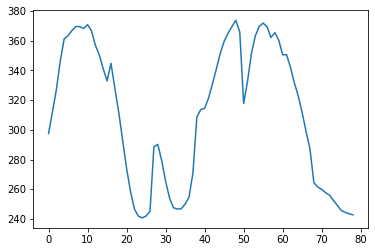

In [32]:
plt.plot(gru_outputs[0])
plt.show()

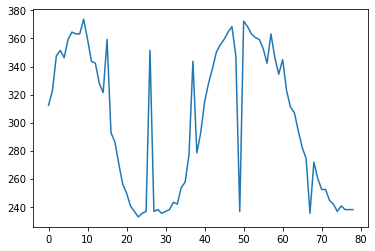

In [33]:
plt.plot(targets[0])
plt.show()